In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model.nn_model import VAEClassifier, StAEClassifier

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 256
epoch_num = 32 # small epoch number for demo
classification_weight = 8

In [3]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])), batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
vae_classifier = VAEClassifier()
stae_classifier = StAEClassifier()
vae_classifier = vae_classifier.to(device)
stae_classifier = stae_classifier.to(device)

In [5]:
CE_Loss = nn.CrossEntropyLoss()
mseloss = torch.nn.MSELoss()
optimizer1 = torch.optim.Adam(vae_classifier.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(stae_classifier.parameters(), lr=1e-4)

In [6]:
for epoch in range(epoch_num):
    vae_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        x_reconst, z, y, mu, log_var = vae_classifier(data, deterministic=False, classification_only=False)
        recons_loss = torch.sum((x_reconst - data) ** 2)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp()) 
        # jointly training
        loss_val = CE_Loss(y, target) * classification_weight * batch_size + recons_loss + kld_loss
        optimizer1.zero_grad()
        loss_val.backward()
        optimizer1.step()

vae_classifier.eval()
torch.save(vae_classifier.state_dict(), './model/vae_clf.pth')

In [7]:
for epoch in range(epoch_num):
    stae_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        x_reconst, z, y = stae_classifier(data, classification_only=False)
        loss_val = CE_Loss(y, target) * classification_weight * batch_size + torch.sum((x_reconst - data) ** 2)
        optimizer2.zero_grad()
        loss_val.backward()
        optimizer2.step()

stae_classifier.eval()
torch.save(stae_classifier.state_dict(), './model/stae_clf.pth')

# Evaluation on testing data

In [8]:
vae_classifier = vae_classifier.eval()
stae_classifier = stae_classifier.eval()
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),])), batch_size=batch_size, shuffle=False, num_workers=4)

# Standard-AE-Classifier

In [9]:
pred_list = []
gt_list = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    x_reconst, z, y_test = stae_classifier(data, classification_only=False)
    pred_list += list(y_test.argmax(-1).cpu().detach().numpy())
    gt_list += list(target.detach().cpu().numpy())

acc = np.sum(np.array(gt_list) == np.array(pred_list)) / len(gt_list)
print(acc)

0.9017


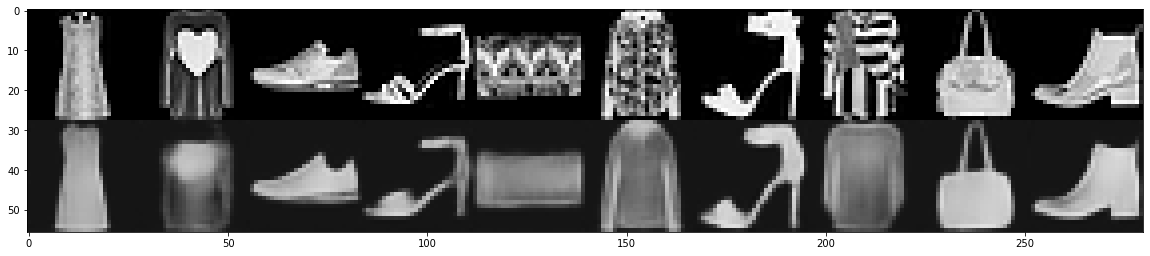

In [10]:
plt.figure(figsize=(20,5))
reconst_sample = np.concatenate(x_reconst[:10,0].detach().cpu().numpy(), axis=1)
input_sample = np.concatenate(data[:10,0].detach().cpu().numpy(), axis=1)
plt.imshow(np.concatenate([input_sample, reconst_sample], axis=0), cmap='gray')
plt.show()

# VAE-Classifier

In [11]:
pred_list = []
gt_list = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    x_reconst, z, y_test, mu, log_var = vae_classifier(data, deterministic=True, classification_only=False)
    pred_list += list(y_test.argmax(-1).cpu().detach().numpy())
    gt_list += list(target.detach().cpu().numpy())

acc = np.sum(np.array(gt_list) == np.array(pred_list)) / len(gt_list)
print(acc)

0.9219


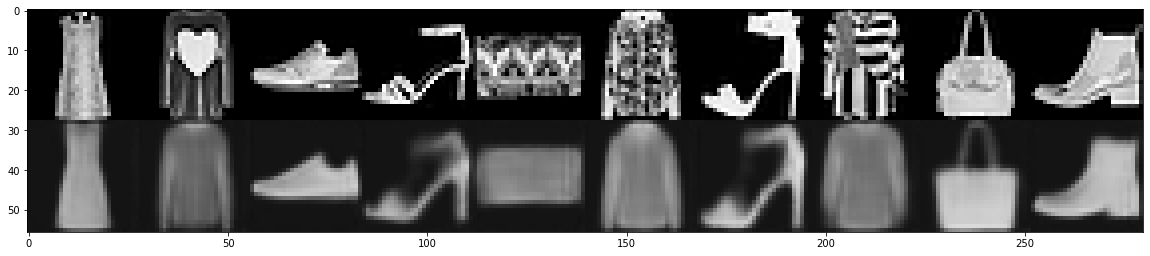

In [12]:
plt.figure(figsize=(20,5))
reconst_sample = np.concatenate(x_reconst[:10,0].detach().cpu().numpy(), axis=1)
input_sample = np.concatenate(data[:10,0].detach().cpu().numpy(), axis=1)
plt.imshow(np.concatenate([input_sample, reconst_sample], axis=0), cmap='gray')
plt.show()